In [ ]:
#default_exp calibration

# Calibration  

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2 

cd '/home/frank/Work/Projecten/DoRe/viz/raw_nmf'

%matplotlib notebook

import maxrf4u 

In [ ]:
#hide 
%%writefile /home/frank/Work/Projecten/DoRe/code/maxrf4u/__init__.py 
from .storage import *
from .calibration import * 
from .hotmax import * 

Overwriting /home/frank/Work/Projecten/DoRe/code/maxrf4u/__init__.py


Inconveniently, ma-xrf data does not always include information about the energy calibration of the spectra. Thus, a very first step in the data analysis is to obtain the energy calibration in keV units (kilo-electron-Volt) for a given dataset. Fortunately, XRF spectra, (at least for drawings), typically have two clearly recognizable features that allow for energy calibration of the detector channels. 

## Two steps 

The automatic energy calibration is done in two steps. In the first step the dominant broad Compton peak is observed in the sum spectrum. The position of this peak can not be used for the calibration directly due to an unknown (detector angle specific) Compton shift, but it serves as a landmark. Right next to the Compton peak a small peak is found. In our lab an x-ray tube with a Rhodium anode is used. This peak can now be attributed to elastic scattering of the strong Rhodium K-alpha emission peak present in the x-ray tube spectrum at 20.21 keV.   

In the second step of the calibration process the iron K-alpha emission peak is located in the max spectrum. Essentially all artifacts like paper contain iron, with a known strong emission K-alpha line at 6.403 keV.  

As a first requisite step in any further data analysis the function `calibrate()` is called. The user is prompted to inspect and save the result.   

<IPython.core.display.Javascript object>


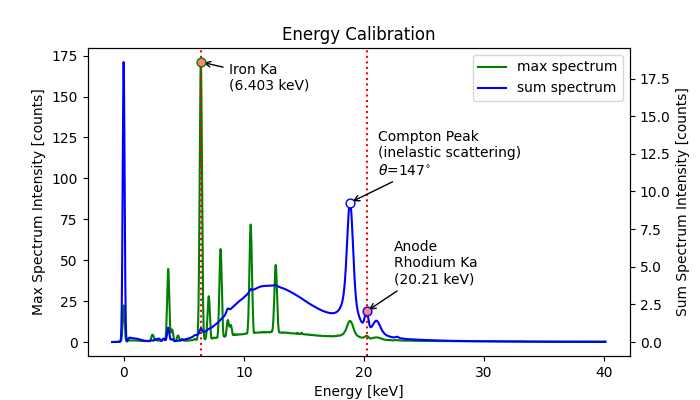

Write energy calibration to datastack file [y/n]? n


In [ ]:
from maxrf4u import calibrate, DataStack

x_keVs = calibrate('RP-T-1898-A-3689.datastack')

In further analysis our stored energy calibration can now be accessed using the `DataStack.read_energies()` method which returns an array with 4096 energy values. 

In [ ]:
ds = DataStack('RP-T-1898-A-3689.datastack')
x_keVs = ds.read_energies()
print(x_keVs)

[-0.98188629 -0.97185221 -0.96181812 ... 40.08763102 40.09766511
 40.1076992 ]


In [ ]:
print(f'Number of energy channels: {len(x_keVs)}')

Number of energy channels: 4096


### `maxrf4u.calibration.py`

In [ ]:
#export 

#%%writefile /home/frank/Work/Projecten/DoRe/code/maxrf4u/calibration.py 

# See development notebook: ~/Work/Projecten/DoRe/notebooks/2021-03-05-maxrf4u-dev.ipynb 

import maxrf4u 
import matplotlib.pyplot as plt 
import numpy as np 
import scipy.signal as ssg 
import matplotlib.cm as cm 
import math

RHODIUM_Ka = 20.210105052526263 # Rh_KL3 
IRON_Ka = 6.4032016008004 # Fe_KL3 

def calibrate(datastack_file, anode='Rh', prominence=0.1): 
    '''Automatic two step energy energy calibration. 
    
    1) In step 1 a preliminary calibration is done assuming that the  
    sensor peak is located at 0 keV and the Rhodium anode Ka peak 
    is next to it's high and broad Compton scattering peak in the sum spectrum. 
    
    2) This preliminary calibration the enables the identification of Fe_Ka and a 
    second precise calibration.'''
    
    assert anode == 'Rh', NotImplementedError('Sorry, need to implement other anode materials!') 
    
    ds = maxrf4u.DataStack(datastack_file)
    
    y_max = ds.read_maxspectrum()
    y_sum = ds.read_sumspectrum()
    
    #RHODIUM_Ka = 20.210105052526263 # Rh_KL3 
    #IRON_Ka = 6.4032016008004 # Fe_KL3 

    # find sensor and anode peaks in sum spectrum 
    n_channels = len(y_sum) 
    x_indices = np.arange(n_channels)
    sum_peak_indices, shapes_dict = ssg.find_peaks(y_sum, prominence=prominence)
    max_peak_indices, shapes_dict = ssg.find_peaks(y_max, prominence=prominence)
    peaks_y = y_sum[sum_peak_indices]
    
    # STEP 1: PRELIMINARY SENSOR + ANODE CALIBRATION TO LOCATE IRON Fe_Ka PEAK  

    # clean spectrum by removing (typically highest) sensor peak  
    n_sensor = n_channels // 20
    y_sum_clean = y_sum.copy()
    y_sum_clean[0:n_sensor] = 0 

    # Now assume highest peak in clean spectrum 
    # is Compton scattering of anode Ka emission  
    compton_i = np.argmax(y_sum_clean) 
    
    # find anode peak channel index right next to Compton peak    
    right_peak_i = sum_peak_indices[list(sum_peak_indices).index(compton_i) + 1] 
    right_keV = RHODIUM_Ka

    # assume sensor peak energy is zero   
    left_peak_i = sum_peak_indices[0]
    left_keV = 0

    # determine sensor + anode based preliminary calibration 
    slope = (right_keV - left_keV) / (right_peak_i - left_peak_i) 
    offset = left_keV - slope * left_peak_i  
    keVs_precalib = slope * x_indices + offset 

    # STEP 2: PRECISE IRON Ka + ANODE CALIBRATION   
    peak_keVs_precalib = keVs_precalib[max_peak_indices]

    # now find index of peak nearest to Fe_Ka energy 
    iron_peak_i = np.argmin((peak_keVs_precalib - IRON_Ka)**2)
    
    # calibrate again now with iron Ka left hand peak 
    
    left_peak_i = max_peak_indices[iron_peak_i]
    left_keV = IRON_Ka

    slope = (right_keV - left_keV) / (right_peak_i - left_peak_i) 
    offset = left_keV - slope * left_peak_i  
    x_keVs = slope * x_indices + offset 
    
    # Calibration peak diagnostics 
    iron_xy = x_keVs[left_peak_i], y_max[left_peak_i]
    compton_xy = x_keVs[compton_i], y_sum[compton_i]
    anode_xy = x_keVs[right_peak_i], y_sum[right_peak_i] 
    
    theta = detector_angle(compton_xy[0], anode_xy[0])
    
    calib_peaks_x, calib_peaks_y = np.array([iron_xy, compton_xy, anode_xy]).T 
    
    # Create calibration plot 
    plt.ion()

    colors =  cm.tab10([0, 1, 2]) 
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[7, 4])
    ax2 = ax.twinx()
    line1, = ax.plot(x_keVs, y_max, label='max spectrum', color='green')
    line2, = ax2.plot(x_keVs, y_sum, label='sum spectrum', color='blue')


    # annotate iron in max spectrum 
    ax.axvline(iron_xy[0], linestyle=':', color='r')
    ax.annotate(f'Iron Ka \n({iron_xy[0]:.3f} keV)', iron_xy, xytext=[20, -20], 
                textcoords='offset points', ha='left', 
                arrowprops=dict(arrowstyle="->", facecolor='grey'))
    ax.scatter(*iron_xy, s=40, facecolor=[1, 0.5, 0.5], edgecolor='green', zorder=10) 

    ax.set_title('Energy Calibration')
    ax.set_xlabel('Energy [keV]')
    ax.set_ylabel('Max Spectrum Intensity [counts]')


    # annotate compton peak in sum spectrum 
    ax2.annotate('Compton Peak\n(inelastic scattering)\n' + 
                r'$\theta$' + f'={int(theta)}' + r'$^{\circ}$', 
                compton_xy, xytext=[20, 20], 
                textcoords='offset points', ha='left', 
                arrowprops=dict(arrowstyle="->", facecolor='grey'))
    ax2.scatter(*compton_xy, s=40, facecolor='white', edgecolor='blue', zorder=10)       

    # annotate anode peak in sum spectrum 
    ax2.axvline(anode_xy[0], linestyle=':', color='r')
    ax2.annotate(f'Anode\nRhodium Ka \n({anode_xy[0]:.2f} keV)', anode_xy, xytext=[20, 20], 
                textcoords='offset points', ha='left', 
                arrowprops=dict(arrowstyle="->", facecolor='grey'))
    ax2.scatter(*anode_xy, s=40, facecolor=[1, 0.5, 0.5], edgecolor=[0, 0, 1], zorder=10)        

    ax2.set_ylabel('Sum Spectrum Intensity [counts]')

    ax.legend(handles=[line1, line2], loc='upper right')

        
    # force updating plot 
    plt.pause(0.2)
    fig.canvas.draw()
        
    # write energies 
    write = input('Write energy calibration to datastack file [y/n]? ')

    if write == 'y': 
        print(f'\nWriting channel energies (keV) to: {datastack_file}')
        maxrf4u.append(x_keVs, maxrf4u.MAXRF_ENERGIES, ds.datastack_file) 
            
    return x_keVs


def detector_angle(keV0, keV1): 
    '''Calculate detector angle *theta* (degrees) 
    
    from Compton peak energy *keV0* and anode energy *keV1* and . '''
    
    assert keV0 < keV1, 'Compton energy should be less then anode energy'

    # constants 
    e = 1.602e-19 # electron charge
    pi = math.pi
    h = 6.62607e-34 # Planck constant 
    m0 = 9.10939e-31 # electron mass 
    c = 2.998e8 # speed of light 
    
    
    # convert keV to Joule 
    E0 = 1000 * keV0 * e 
    E1 = 1000 * keV1 * e 

    theta = (180 / pi) * np.arccos(1 - m0 * c**2 * (1/E0 - 1/E1))

    return theta

Overwriting /home/frank/Work/Projecten/DoRe/code/maxrf4u/calibration.py


In [ ]:
#hide 
# force deep reload 
import maxrf4u
import sys
del sys.modules['maxrf4u.calibration']
del sys.modules['maxrf4u.storage']
del sys.modules['maxrf4u']

import maxrf4u 
import numpy as np 